In [68]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from functools import partial

import warnings

warnings.filterwarnings("ignore")

np.set_printoptions(threshold=5, suppress=True, linewidth=10**3)
sns.set(style="whitegrid")

## Simulation study

Let us consider the Merton jump-diffusion model
$$
M_t = \exp \left\{\mu t + \sigma W_t + \sum\limits_{i=1}^{N_t} \xi_i \right\},
$$
where $W_t \sim N(0, t), N_t \sim Pois(\lambda t)$ and $\xi_i \sim N(0, 1)$.

As $|u| \rightarrow \infty$ approximately
$$
\varphi_{\Delta}(u) \approx i \mu u - \frac{1}{2} \sigma^2 u^2 - \lambda
$$

The parameters are chosen to be $\mu = 0, \sigma = 1, \lambda = 10$ and $\Delta = 0.1$.

Thus,
$$
Re(\varphi_{\Delta}(u)) \approx -\frac{1}{2} u^2 - 10
$$

In [97]:
mu, sig, lam, dt = 0, 1, 10, 0.1
n_obs, samples, seed = 10**3, 25, 25

In [98]:
u_grid = np.linspace(0, 10, n_obs)

print(u_grid.shape)
u_grid[:10]

(1000,)


array([0.        , 0.01001001, 0.02002002, ..., 0.07007007, 0.08008008, 0.09009009])

In [99]:
Deltas = (np.ones(shape=n_obs + 1) * dt) * np.arange(n_obs + 1)

print(Deltas.shape)
Deltas[:12]

(1001,)


array([0. , 0.1, 0.2, ..., 0.9, 1. , 1.1])

### Brownian motion

Note that $B_{k \Delta} = \sum\limits_{j=1}^k \left[ B_{j \Delta} - B_{(j - 1) \Delta} \right]$, where $B_{j \Delta} - B_{(j - 1)} \sim N(0, \; \Delta).$

In [100]:
np.random.seed(seed)

W_increments = sts.norm.rvs(loc=0, scale=np.sqrt(dt), size=(samples, n_obs))
W_path = np.cumsum(W_increments, axis=1)
W_path = np.insert(W_path, 0, 0, axis=1)

# print(W_path.shape)
# W_path

In [101]:
# plt.figure(figsize=(14, 7))
# plt.grid(True)
# for i in range(samples):
#     plt.plot(Deltas, W_path[i])
# 
# plt.xlabel('Time')
# plt.ylabel('Brownian motion')
# 
# plt.savefig('Brownian motion')
# plt.show()

### Poisson process

Similarly $N_{k \Delta} = \sum\limits_{j=1}^{k} \left[ N_{j \Delta} - N_{(j - 1) \Delta} \right]$, where $N_{j \Delta} - N_{(j - 1) \Delta} \sim Pois(\lambda \Delta)$.

In [102]:
np.random.seed(seed)

N_increments = sts.poisson.rvs(mu=lam * dt, size=(samples, n_obs))
N_path = np.cumsum(N_increments, axis=1)
N_path = np.insert(N_path, 0, 0, axis=1)

# print(N_path.shape)
# N_path

In [103]:
# plt.figure(figsize=(14, 7))
# plt.grid(True)
# for i in range(samples):
#     plt.step(Deltas[:10], N_path[i][:10], where="post")
# 
# plt.xlabel('Time')
# plt.ylabel('Poisson process')
# 
# plt.savefig('Poisson process')
# plt.show()

### Compound Poisson process

In [105]:
np.random.seed(seed)

chi_seq = sts.norm.rvs(loc=0, scale=1, size=(samples, np.max(N_path[:, -1])))
chi_sum = np.cumsum(chi_seq, axis=1)
chi_sum = np.insert(chi_sum, 0, 0, axis=1)

CPP_path = np.array([np.array([chi_sum[i][n_t] for n_t in N_path[i]]) for i in range(samples)])
# CPP_path

In [106]:
# plt.figure(figsize=(14, 7))
# plt.grid(True)
# for i in range(samples):
#     plt.plot(Deltas, CPP_path[i])
# 
# plt.xlabel('Time')
# plt.ylabel('CPP')
# 
# plt.savefig('CPP.png')
# plt.show()

### Estimation

In [107]:
M_kDel = np.exp(mu * Deltas + sig * W_path + CPP_path)

# print(M_kDel.shape)
# M_kDel

It is known that
$$
D_k = \log M_{k \Delta} - \log M_{(k - 1) \Delta}
$$

In [108]:
D_k = np.log(M_kDel[:, 1:]) - np.log(M_kDel[:, :-1])

# print(D_k.shape)
# D_k

$$
\hat{\varphi}_{\Delta}(u) = -\frac{1}{\Delta} \log n + \frac{1}{2 \Delta} \log \left[ \left( \sum\limits_{k=1}^n \cos(u D_k) \right)^2 + \left(\sum\limits_{k=1}^n \sin(u D_k) \right)^2 \right] + i \frac{1}{\Delta} \arctan \left(\frac{\sum_{k=1}^n \sin(u D_k))}{\sum_{k=1}^n \cos(u D_k)} \right)_.
$$

In [109]:
# def re_estimation(n_obs, i, dt, D_k, u_grid):
#     cos_sum = np.array([arr.sum()**2 for arr in [np.cos(u * D_k[i]) for u in u_grid]])
#     sin_sum = np.array([arr.sum()**2 for arr in [np.sin(u * D_k[i]) for u in u_grid]])
#     re_hat = -1 / dt * np.log(n_obs) + 1 / (2 * dt) * np.log(cos_sum + sin_sum)
#     return re_hat

In [110]:
# re_approx = -1 / 2 * u_grid**2 - 10
# re = -1 / 2 * u_grid**2 - 10 + 10 * np.exp(-1 / 2 * u_grid**2)

In [111]:
# plt.figure(figsize=(11, 7))
# 
# sns.set(style="whitegrid")
# # plt.title(f'for sample size = {n_obs}')
# 
# sns.lineplot(x=u_grid, y=re_approx, color='r', label='re_approx')
# sns.lineplot(x=u_grid, y=re, color='orange', label='re_fact')
# 
# re_hat_0 = re_estimation(n_obs, 0, dt, D_k, u_grid)
# sns.lineplot(x=u_grid, y=re_hat_0, lw=0.5, alpha=0.5, color='b', label='re_hat_0')
# 
# for i in range(1, samples):
#     re_hat_0 = re_estimation(n_obs, i, dt, D_k, u_grid)
#     sns.lineplot(x=u_grid, y=re_hat_0, lw=0.5, alpha=0.5, color='b')
# 
# plt.xlabel('u')
# plt.ylabel('func')
# 
# plt.savefig('Re')
# plt.show()

It can be seen that three lines are close to each other in interval $[2, 6]$

## Algorithm 1

In [112]:
# def re_estimation(n_obs, i, dt, D_k, u_grid):
#     cos_sq_sum = np.array([arr.sum()**2 for arr in [np.cos(u * D_k[i]) for u in u_grid]])
#     sin_sq_sum = np.array([arr.sum()**2 for arr in [np.sin(u * D_k[i]) for u in u_grid]])
#     re_hat = (-1 / dt) * np.log(n_obs) + 1 / (2 * dt) * np.log(cos_sq_sum + sin_sq_sum)
#     return re_hat

In [113]:
# # Functions
# def Lam_d(d: int, eps: float, u_til: np.ndarray) -> float:
#     w = (eps <= u_til) & (u_til <= 1)
#     return (w * u_til**(2 * d)).sum()
# 
# 
# def Psi_d(
#     n_obs: int, i:int, dt: float, D_k: np.ndarray,
#     d: int, eps: float, U_n: float, u_til: np.ndarray 
# ) -> float:
#     
#     w = (eps <= u_til) & (u_til <= 1)
#     re_hat = re_estimation(n_obs, i, dt, D_k, u_til * U_n)
#     return (w * re_hat * (u_til * U_n)**(2 * d)).sum()
# 
# 
# def Epsilon(u_til: float, u_V: float):
#     return ((eps <= u_til) & (u_til <= 1)) * np.imag(phi_estimation_partial(u_V)) * u_V

In [114]:
# # Initiate
# eps, U_n, V_n = 0.5, 6, 6
# N = 10**3
# div = np.linspace(eps, 1, N - 1)
# 
# # Lets compute u_tilda
# u_til = np.arange(len(div) - 1)
# u_til = np.vectorize(lambda i: np.random.uniform(div[i], div[i + 1]))(u_til)
# u_til = np.insert(u_til, 0, eps)
# u_til = np.append(u_til, 1)
# 
# print(u_til.shape)
# u_til

It is known that

$$
\begin{cases}
    \sigma^2_n = 2 \frac{\Psi_0 \Lambda_1 U_n^2 - \Psi_1 \Lambda_0}{(\Lambda_2 \Lambda_0 - \Lambda_1^2) U_n^4} \\
    \lambda_n = \frac{\Psi_1 \Lambda_1 - \Psi_0 \Lambda_2 U_n^2}{(\Lambda_2 \Lambda_0 - \Lambda_1^2) U_n^2}
\end{cases}
$$

Then

In [115]:
# Lam_0 = Lam_d(0, eps, u_til)
# Lam_1 = Lam_d(1, eps, u_til)
# Lam_2 = Lam_d(2, eps, u_til)
# 
# Psi_0 = Psi_d(n_obs, 5, dt, D_k, 0, eps, U_n, u_til)
# Psi_1 = Psi_d(n_obs, 5, dt, D_k, 1, eps, U_n, u_til)

In [116]:
# # Calculations based on one sample
# sig_n = 2 * (Psi_0 * Lam_1 * U_n**2 - Psi_1 * Lam_0) / ((Lam_2 * Lam_0 - Lam_1**2) * U_n**4)
# print(f"sig_n: {sig_n}")
# 
# lam_n = (Psi_1 * Lam_1 - Psi_0 * Lam_2 * U_n**2) / ((Lam_2 * Lam_0 - Lam_1**2) * U_n**2)
# print(f"lam_n: {lam_n}")

In [117]:
# re_hat = -1 / 2 * sig_n**2 * u_grid**2 - lam_n

In [118]:
# plt.figure(figsize=(11, 7))
# 
# sns.set(style="whitegrid")
# plt.title(f'for sample size = {n_obs}')
# 
# sns.lineplot(x=u_grid, y=re_hat, color='b', label='re_hat')
# sns.lineplot(x=u_grid, y=re_approx, color='r', label='re_approx')
# sns.lineplot(x=u_grid, y=re, color='orange', label='re_fact')
# 
# plt.show()

In [119]:
# sigmas_square_1000, lambdas_1000 = [], []
# for i in range(samples):
#     Lam_0 = Lam_d(0, eps, u_til)
#     Lam_1 = Lam_d(1, eps, u_til)
#     Lam_2 = Lam_d(2, eps, u_til)
# 
#     Psi_0 = Psi_d(n_obs, i, dt, D_k, 0, eps, U_n, u_til)
#     Psi_1 = Psi_d(n_obs, i, dt, D_k, 1, eps, U_n, u_til)
#     
#     sig_n = 2 * (Psi_0 * Lam_1 * U_n**2 - Psi_1 * Lam_0) / ((Lam_2 * Lam_0 - Lam_1**2) * U_n**4)
#     sigmas_square_1000.append(sig_n**2)
# 
#     lam_n = (Psi_1 * Lam_1 - Psi_0 * Lam_2 * U_n**2) / ((Lam_2 * Lam_0 - Lam_1**2) * U_n**2)
#     lambdas_1000.append(lam_n)

In [120]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# 
# sns.boxplot(y=sigmas_square_1000, ax=axes[0])
# axes[0].set_title('sigmas_square')
# axes[0].set_xlabel('n_obs=1000')
# 
# sns.boxplot(y=lambdas_1000, ax=axes[1])
# axes[1].set_title('lambdas')
# axes[1].set_xlabel('n_obs=1000')
# 
# plt.savefig('boxplot1000')
# plt.show()

----

In [121]:
def re_estimation(n_obs, i, dt, D_k, u_grid):
    cos_sq_sum = np.array([arr.sum()**2 for arr in [np.cos(u * D_k[i]) for u in u_grid]])
    sin_sq_sum = np.array([arr.sum()**2 for arr in [np.sin(u * D_k[i]) for u in u_grid]])
    re_hat = -1 / dt * np.log(n_obs) + 1 / (2 * dt) * np.log(cos_sq_sum + sin_sq_sum)
    return re_hat


def im_estimation(i, dt, D_k, u_grid):
    cos_sum = np.array([arr.sum() for arr in [np.cos(u * D_k[i]) for u in u_grid]])
    sin_sum = np.array([arr.sum() for arr in [np.sin(u * D_k[i]) for u in u_grid]])
    im_hat = (1 / dt) * np.arctan(sin_sum / cos_sum)
    return im_hat


# Functions
def Lam_d(d: int, eps: float, u_til: np.ndarray) -> float:
    w = (eps <= u_til) & (u_til <= 1)
    return (w * u_til**(2 * d)).sum()


def Psi_d(
    n_obs: int, i:int, dt: float, D_k: np.ndarray,
    d: int, eps: float, U_n: float, u_til: np.ndarray 
) -> float:
    
    w = (eps <= u_til) & (u_til <= 1)
    re_hat = re_estimation(n_obs, i, dt, D_k, u_til * U_n)
    return (w * re_hat * (u_til * U_n)**(2 * d)).sum()


def Epsilon(
    i:int, dt: float, D_k: np.ndarray,
    eps: float, V_n: float, u_til: np.ndarray 
):
    
    w = (eps <= u_til) & (u_til <= 1)
    im_hat = im_estimation(i, dt, D_k, u_til * V_n)
    return (w * im_hat * u_til * V_n).sum()


def kernel(x):
    if abs(x) <= 0.05:
        return 1
    elif 0.05 < abs(x) and abs(x) < 1:
        return np.exp(-np.exp(-1 / (abs(x) - 0.05)) / (1 - abs(x)))
    return 0


def phi_estimation(
    i: int, n_obs: int, dt: float, u_arc: np.ndarray, D_k: np.ndarray
):
    
    return np.array([(1 / dt) * np.log((1 / n_obs) * np.sum(np.exp(1j * u * D_k[i]))) for u in u_arc])


def density_estimation(
    i: int, n_obs: int, dt: float, T_n: float, delta: float, lam_n: float, sig_n: float, mu_n: float,
    u_arc: np.ndarray, D_k: np.ndarray, x_s: float
):
    
    phi_est = phi_estimation(i, n_obs, dt, u_arc, D_k)
    
    
    
    #phi_est = re_estimation(n_obs, i, dt, D_k, u_arc) + 1j * im_estimation(i, dt, D_k, u_arc)
    
    
    kern = np.array([kernel(u / T_n) for u in u_arc])
    # kern = 1
    
    return ((T_n * delta) / (2 * np.pi * lam_n)) * np.sum(
        np.exp(-1j * u_arc * x_s) * (phi_est - 1j * mu_n * u_arc + (1 / 2) * sig_n**2 * u_arc**2 + lam_n) * kern
    )

In [26]:
def real_parts_graph(n_obs, dt, D_k, u_grid):
    re_approx = -1 / 2 * u_grid**2 - 10
    
    #???
    re = -1 / 2 * u_grid**2 - 10 + 10 * np.exp(-1 / 2 * u_grid**2)
    
    plt.figure(figsize=(11, 7))

    sns.set(style="whitegrid")
    plt.title(f'for sample size = {n_obs}')
    
    sns.lineplot(x=u_grid, y=re_approx, color='r', label='re_approx')
    sns.lineplot(x=u_grid, y=re, color='orange', label='re_fact')
    
    re_hat_0 = re_estimation(n_obs, 0, dt, D_k, u_grid)
    sns.lineplot(x=u_grid, y=re_hat_0, lw=0.5, alpha=0.5, color='b', label='re_hat_0')
    
    for i in range(1, samples):
        re_hat_0 = re_estimation(n_obs, i, dt, D_k, u_grid)
        sns.lineplot(x=u_grid, y=re_hat_0, lw=0.5, alpha=0.5, color='b')
    
    plt.xlabel('u')
    plt.ylabel('func')
        
    plt.show()
    
    
def estimation_boxplots(sigmas_square, lambdas, n_obs):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    sns.boxplot(y=sigmas_square, ax=axes[0])
    axes[0].set_title('sigmas_square')
    axes[0].set_xlabel(f'n_obs = {n_obs}')
    
    sns.boxplot(y=lambdas, ax=axes[1])
    axes[1].set_title('lambdas')
    axes[1].set_xlabel(f'n_obs = {n_obs}')
    
    plt.show()


def estimation(
    mu:float, sig:float, lam:float, dt:float,
    n_obs:int, samples:int, seed:int
):
    """
    """
    # Fixing random seed
    np.random.seed(seed)
    
    # 
    u_grid1 = np.linspace(0, 10, n_obs)
    Deltas = (np.ones(shape=n_obs + 1) * dt) * np.arange(n_obs + 1)
    
    
    W_increments = sts.norm.rvs(loc=0, scale=np.sqrt(dt), size=(samples, n_obs))
    W_path = np.cumsum(W_increments, axis=1)
    W_path = np.insert(W_path, 0, 0, axis=1)
    
    N_increments = sts.poisson.rvs(mu=lam * dt, size=(samples, n_obs))
    N_path = np.cumsum(N_increments, axis=1)
    N_path = np.insert(N_path, 0, 0, axis=1)
    
    xi_seq = sts.norm.rvs(loc=0, scale=1, size=(samples, np.max(N_path[:, -1])))
    xi_sum = np.cumsum(xi_seq, axis=1)
    xi_sum = np.insert(xi_sum, 0, 0, axis=1)
    
    CPP_path = np.array([np.array([xi_sum[i][n_t] for n_t in N_path[i]]) for i in range(samples)])
    
    M_kDel = np.exp(mu * Deltas + sig * W_path + CPP_path)
    
    D_k = np.log(M_kDel[:, 1:]) - np.log(M_kDel[:, :-1])
    
    #
    # real_parts_graph(n_obs, dt, D_k, u_grid)
    

    # Initiate for params
    eps, U_n, V_n = 0.5, 6, 6
    N = n_obs
    div = np.linspace(eps, 1, N + 1)
    
    # Lets compute u_tilda
    u_til1 = np.arange(len(div) - 1)
    u_til1 = np.vectorize(lambda i: np.random.uniform(div[i], div[i + 1]))(u_til1)
    
    
    #Initiate for density
    m = 10**2
    x_s = np.linspace(-5, 5, m)
    
    N = n_obs
    T_n = 3.3
    delta = 2 / N
    
    u_grid2 = np.linspace(-1, 1, N - 1)
    
    u_til2 = np.array([np.random.uniform(u_grid2[i - 1], u_grid2[i]) for i in range(1, len(u_grid2))])
    u_til2 = np.insert(u_til2, 0, -1)
    u_til2 = np.append(u_til2, 1)
    
    u_arc = T_n * u_til2
    
    sigmas_square, lambdas, mus = [], [], []
    estimated_densities = []
    
    
    for i in tqdm(range(samples)):
        Lam_0 = Lam_d(0, eps, u_til1)
        Lam_1 = Lam_d(1, eps, u_til1)
        Lam_2 = Lam_d(2, eps, u_til1)
    
        Psi_0 = Psi_d(n_obs, i, dt, D_k, 0, eps, U_n, u_til1)
        Psi_1 = Psi_d(n_obs, i, dt, D_k, 1, eps, U_n, u_til1)
        
        Eps = Epsilon(i, dt, D_k, eps, V_n, u_til1)
        
        sig_n = 2 * (Psi_0 * Lam_1 * U_n**2 - Psi_1 * Lam_0) / ((Lam_2 * Lam_0 - Lam_1**2) * U_n**4)
        sigmas_square.append(sig_n**2)
    
        lam_n = (Psi_1 * Lam_1 - Psi_0 * Lam_2 * U_n**2) / ((Lam_2 * Lam_0 - Lam_1**2) * U_n**2)
        lambdas.append(lam_n)
        
        mu_n = Eps / (Lam_1 * V_n**2)
        mus.append(mu_n)
        
        p_estimated = np.array([density_estimation(i, n_obs, dt, T_n, delta, lam_n, sig_n, mu_n, u_arc, D_k, x) for x in x_s])
        estimated_densities.append(p_estimated)
        
        # sns.lineplot(x=x_s, y=p_estimated, color='blue', linewidth=0.5)
        
        # plt.show()
        
        
    # estimation_boxplots(sigmas_square, lambdas, n_obs)
    return sigmas_square, lambdas, mus, estimated_densities

In [122]:
# sigmas_square_1000, lambdas_1000, mus_1000, est_den1000 = estimation(0, 1, 10, 0.1, 10**3, samples, seed)

100%|███████████████████████████████████████████| 25/25 [01:13<00:00,  2.93s/it]


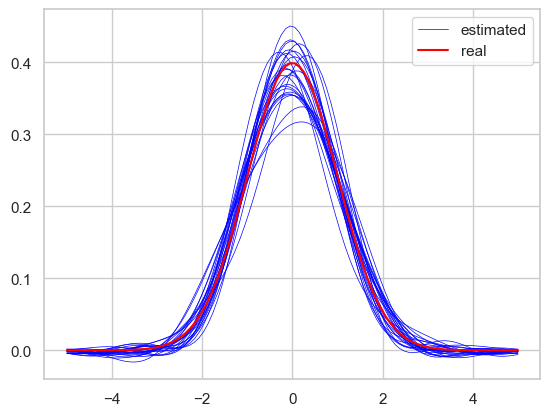

In [123]:
m = 10**2
x_s = np.linspace(-5, 5, m)
p_real = (1 / np.sqrt(2 * np.pi)) * np.exp(-x_s**2 / 2)

sns.lineplot(x=x_s, y=est_den1000[0], color='blue', linewidth=0.5, label='estimated')

MSE_1000 = []
for dens in est_den1000[1:]:
    MSE_1000.append((1 / m) * np.sum((dens - p_real)**2))
    sns.lineplot(x=x_s, y=dens, color='blue', linewidth=0.5)

sns.lineplot(x=x_s, y=p_real, color='red', label='real')
plt.legend()
plt.show()

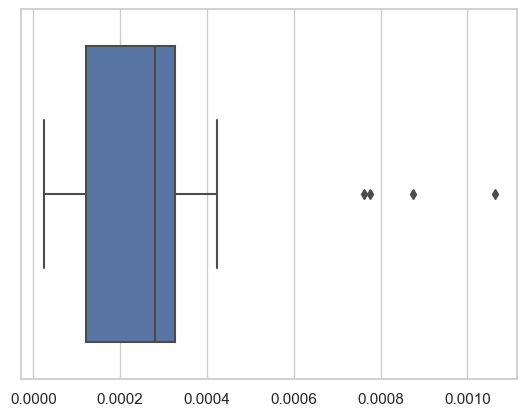

In [124]:
sns.boxplot(MSE_1000)
plt.show()

In [ ]:
# sigmas_square_5000, lambdas_5000, mus_5000, est_den5000 = estimation(0, 1, 10, 0.1, 5 * 10**3, samples, seed)

 60%|█████████████████████████▊                 | 15/25 [13:39<09:07, 54.72s/it]

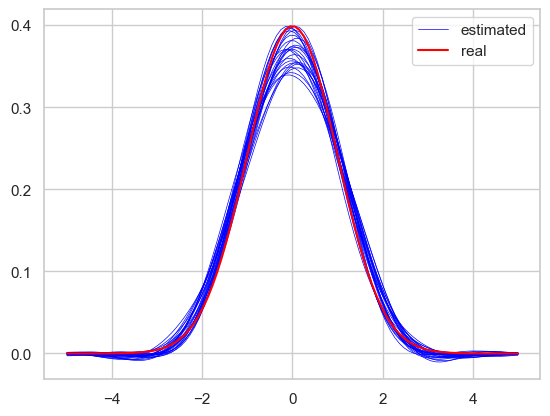

In [72]:
#m = 10**2
#x_s = np.linspace(-5, 5, m)
#p_real = (1 / np.sqrt(2 * np.pi)) * np.exp(-x_s**2 / 2)
#
#sns.lineplot(x=x_s, y=est_den5000[0], color='blue', linewidth=0.5, label='estimated')
#
#MSE_5000 = []
#for dens in est_den5000[1:]:
#    MSE_5000.append((1 / m) * np.sum((dens - p_real)**2))
#    sns.lineplot(x=x_s, y=dens, color='blue', linewidth=0.5)
#
#sns.lineplot(x=x_s, y=p_real, color='red', label='real')
#plt.legend()
#plt.show()

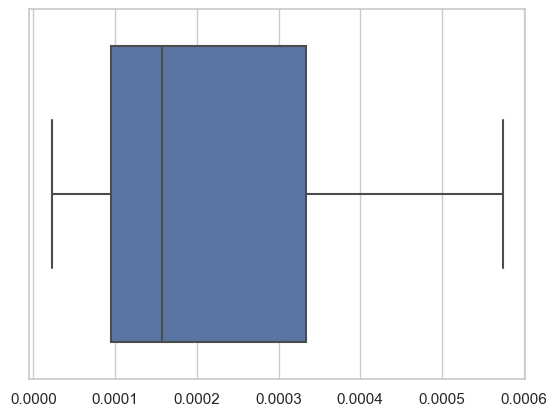

In [73]:
#sns.boxplot(MSE_5000)
#plt.show()

In [74]:
# sigmas_square_10000, lambdas_10000, mus_10000, est_den10000 = estimation(0, 1, 10, 0.1, 10**4, samples, seed)

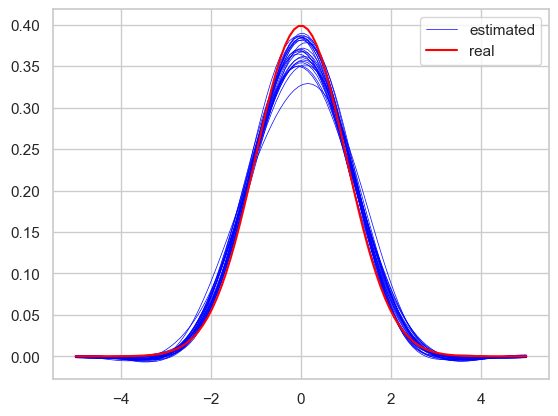

In [75]:
#m = 10**2
#x_s = np.linspace(-5, 5, m)
#p_real = (1 / np.sqrt(2 * np.pi)) * np.exp(-x_s**2 / 2)
#
#sns.lineplot(x=x_s, y=est_den10000[0], color='blue', linewidth=0.5, label='estimated')
#
#MSE_10000 = []
#for dens in est_den10000[1:]:
#    MSE_10000.append((1 / m) * np.sum((dens - p_real)**2))
#    sns.lineplot(x=x_s, y=dens, color='blue', linewidth=0.5)
#
#sns.lineplot(x=x_s, y=p_real, color='red', label='real')
#plt.legend()
#plt.show()

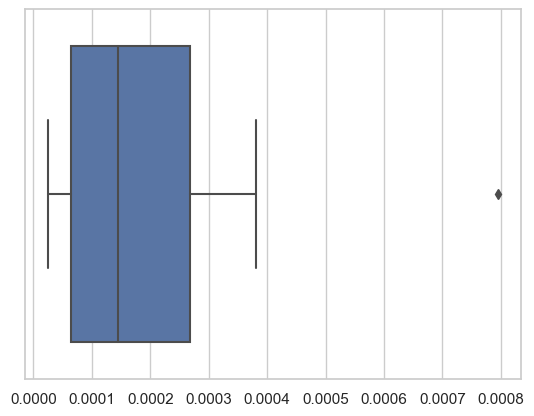

In [76]:
#sns.boxplot(MSE_10000)
#plt.show()

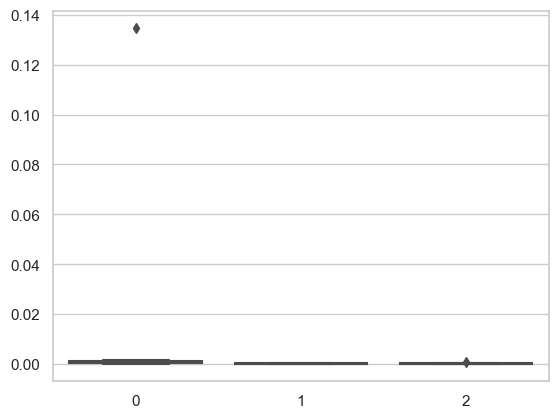

In [79]:
#MSE_data = [MSE_1000, MSE_5000, MSE_10000]
#
#sns.boxplot(data=MSE_data);

In [95]:
est_densities = [est_den1000, est_den5000, est_den10000]
density_labels = ['1000', '5000', '10000']

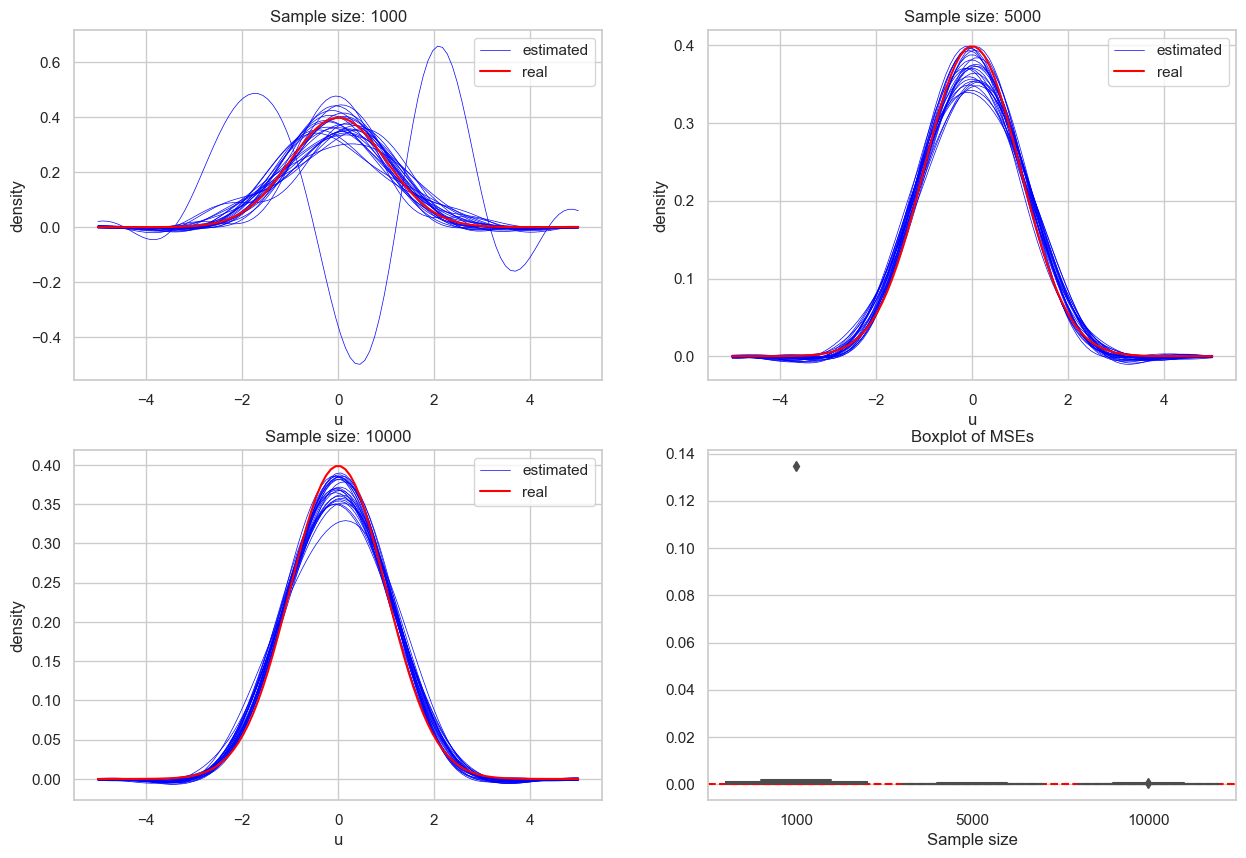

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes = axes.flatten()

for ax, dens_list, sample_size in zip(axes, est_densities, density_labels):
    sns.lineplot(x=x_s, y=dens_list[0], color='blue', linewidth=0.5, label='estimated', ax=ax)
    for dens in dens_list[1:]:
        # Assuming x_s and dens contain data for the line plot
        sns.lineplot(x=x_s, y=dens, color='blue', linewidth=0.5, ax=ax)
        
    sns.lineplot(x=x_s, y=p_real, color='red', label='real', ax=ax)
    
    ax.set_xlabel('u')
    ax.set_ylabel('density')
    ax.set_title(f'Sample size: {sample_size}')


MSE_data = [MSE_1000, MSE_5000, MSE_10000]
sns.boxplot(data=MSE_data, ax=axes[-1])
axes[-1].axhline(y=0, color='red', linestyle='--')
axes[-1].set_xticklabels([1000, 5000, 10000])
axes[-1].set_xlabel('Sample size')
axes[-1].set_title('Boxplot of MSEs')

plt.savefig('densities.png')
plt.show()

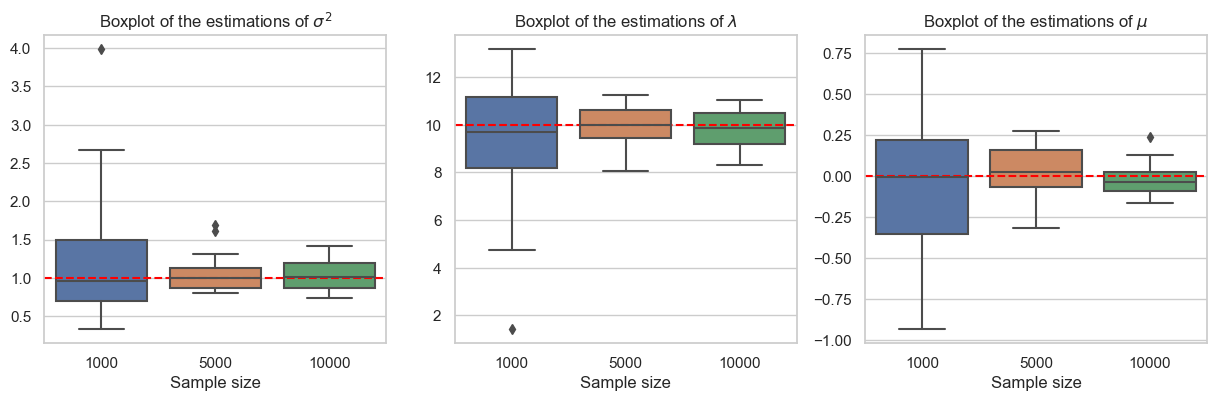

In [36]:
sigmas_square_data = [sigmas_square_1000, sigmas_square_5000, sigmas_square_10000]
lambdas_data = [lambdas_1000, lambdas_5000, lambdas_10000]
mus_data = [mus_1000, mus_5000, mus_10000]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0] = sns.boxplot(data=sigmas_square_data, ax=axes[0])
axes[0].axhline(y=1, color='red', linestyle='--')
axes[0].set_xticklabels([1000, 5000, 10000])
axes[0].set_xlabel('Sample size')
axes[0].set_title(r'Boxplot of the estimations of $\sigma^2$')


axes[1] = sns.boxplot(data=lambdas_data, ax=axes[1])
axes[1].axhline(y=10, color='red', linestyle='--')
axes[1].set_xticklabels([1000, 5000, 10000])
axes[1].set_xlabel('Sample size')
axes[1].set_title(r'Boxplot of the estimations of $\lambda$')

axes[2] = sns.boxplot(data=mus_data, ax=axes[2])
axes[2].axhline(y=0, color='red', linestyle='--')
axes[2].set_xticklabels([1000, 5000, 10000])
axes[2].set_xlabel('Sample size')
axes[2].set_title(r'Boxplot of the estimations of $\mu$')

plt.savefig('boxplots.png')
plt.show()